# HR-аналитика для компании «Работа с заботой»

*Учебный проект в рамках курса "Специалист по Data Science" от Яндекс Практикум.*

**Описание проекта:**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

В данном проекте предстоит решить две задачи:
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

In [1]:
%%capture
!pip install -U scikit-learn
!pip install phik
!pip install shap

In [2]:
import math
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder,
                                   OrdinalEncoder, StandardScaler)

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, make_scorer,
                             precision_score, recall_score, roc_auc_score, roc_curve)


sns.set_theme()

RANDOM_STATE = 42

## Задача 1. Предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

### Загрузка данных

#### Получение наборов данных

In [3]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except FileNotFoundError:
    train_job_satisfaction_rate = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')

#### Изучение информации о датасетах

In [5]:
# выведем основную информацию о датасетах с помощью словаря и функции datasets_overview 
def datasets_overview(df_dict):
    print('Информация о датафреймах:\n')
    for name, df in df_dict.items():
        print(f"{name}:")
        display(df.head())
        df.info()
        print(f"\nНайдено строк-дубликатов: {df.duplicated().sum()}")
        print('------------------------------------------------------------\n')


datasets_dict = {
    'train_job_satisfaction_rate': train_job_satisfaction_rate,
    'test_features': test_features,
    'test_target_job_satisfaction_rate': test_target_job_satisfaction_rate
}       

datasets_overview(datasets_dict)

Информация о датафреймах:

train_job_satisfaction_rate:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

test_target_job_satisfaction_rate:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

Найдено строк-дубликатов: 0
------------------------------------------------------------



**Вывод:** В качестве исходных данных у нас имеется 3 таблицы, предварительный анализ которых позволил выделить следующее:

1. `train_job_satisfaction_rate`, `test_features`:
    - Имена столбцов приведены корректно;
    - Типы данных указаны верно;
    - Полных дубликатов строк не обнаружено;
    - Обнаружены пропуски в столбцах `dept` и `level`.

2. `test_target_job_satisfaction_rate`:
    - Имена столбцов приведены корректно;
    - Типы данных указаны верно;
    - Полных дубликатов строк и пропусков не обнаружено.

### Предобработка данных

#### Проверка на неявные дубликаты

В нашем случае, неявные дубликаты - это строки с одинаковым значением в столбце `id`, т.е. записи про одних и тех же сотрудников. Проверим наличие таких неявных дубликатов.

In [6]:
# проверяем на неявные дубликаты
print(f"""\
Количество неявных дубликатов в train_job_satisfaction_rate: {train_job_satisfaction_rate.duplicated(subset='id').sum()}
Количество неявных дубликатов в test_features: {test_features.duplicated(subset='id').sum()}
Количество неявных дубликатов в test_target_job_satisfaction_rate: {test_target_job_satisfaction_rate.duplicated(subset='id').sum()}
""")

Количество неявных дубликатов в train_job_satisfaction_rate: 0
Количество неявных дубликатов в test_features: 0
Количество неявных дубликатов в test_target_job_satisfaction_rate: 0



#### Проверка уникальных значений в категориальных переменных

Теперь проверим датасеты на наличие ошибок-разночтений в категориальных признаках. Для этого нужно проверить уникальные значения данных признаков - сделаем это с помощью функции. 

In [7]:
# проверим ошибки в категориальных признаках
def cat_col_unique(df_dict):
    for name, df in df_dict.items():
        print(f"{name}:")
        _cat_columns = [col for col in df.columns if df[col].dtype == 'object']
        df[_cat_columns].apply(lambda x: print(f"\t{x.name}: {x.unique()}"))
        print('-----')


cat_col_unique(datasets_dict)

train_job_satisfaction_rate:
	dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
	level: ['junior' 'middle' 'sinior' nan]
	workload: ['medium' 'high' 'low']
	last_year_promo: ['no' 'yes']
	last_year_violations: ['no' 'yes']
-----
test_features:
	dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
	level: ['junior' 'middle' 'sinior' nan]
	workload: ['medium' 'low' 'high' ' ']
	last_year_promo: ['no' 'yes']
	last_year_violations: ['no' 'yes']
-----
test_target_job_satisfaction_rate:
	None: []
-----


Ошибок-разночтений в уникальных значениях категориальных признаков не обнаружено. Однако, можно заметить, что в таблице `test_features`, помимо обнаруженных ранее пропусков, имеются пропуски в виде пробела `' '`. Учтем это при написании пайплайна подготовки данных.

Найденные выше в датасетах `train_job_satisfaction_rate` и `test_features` пропуски-пробелы и пропуски `nan` будем заполнять в пайплайне на этапе подготовке данных и обучения моделей.

На данном шаге нужно определиться со стратегией заполнения пропусков. Так как у нас пропуски в информации об отделе, грейде и уровне загруженности, то заполнить их значением, основанным на каких-то других данных будет проблематично - к примеру, по зарплате трудно сказать в каком отделе работает сотрудник и т.д. Заполнять заглушкой (например "другой") тоже не хочется, т.к. таких пропусков очень мало - не думаю, что это будет существенным вкладом в прогноз будущей модели. Поэтому целесообразно заполнить пропуски самым частовстречающимся значением у соответствующего признака.

Предобработка данных практически завершена. Осталось только установить `id` сотрудников в качестве индексов (при этом нужно отсортировать таблицы по `id`, т.к. у строк в `test_features` и `test_target_job_satisfaction_rate` разный порядок). Но перед этим выполним пару проверок.

In [12]:
# проверим все ли id в тестовой выборке входных признаков есть в таблице с целевой переменной для тестовой выборки
if set(test_features['id']) == set(test_target_job_satisfaction_rate['id']):
    print('id совпадают')
else:
    print('id не совпадают')

id совпадают


In [13]:
# проверим не пересекаются ли данные в тренировочной и тестовой выборках
if len(set(train_job_satisfaction_rate['id']) & set(test_features['id'])) == 0:
    print('Данные не пересекаются')
else:
    print('Данные пересекаются')

Данные не пересекаются


In [14]:
# устанавливаем id в качестве индексов и сортируем по индексу тестовую выборку
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id').sort_index()
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id').sort_index()

In [16]:
display(train_job_satisfaction_rate.head(), test_features.head(), test_target_job_satisfaction_rate.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


Т.к. мы установили стобец `id` в качестве индексов, то в тренировочной выборке (как и в других таблицах) могли появиться строки-дубликаты. Проверим это.

In [18]:
# еще раз проверяем таблицы на полные дубликаты
print(f"""\
Количество полных дубликатов в train_job_satisfaction_rate: {train_job_satisfaction_rate.duplicated().sum()}""")

Количество полных дубликатов в train_job_satisfaction_rate: 245


Теперь в тренировочном фрейме 245 строк-дубликатов. Да, это записи, относящиеся к разным людям, однако для модели это абсолютно одинаковые данные - никаких новых зависимостей модель при обучении в них не найдет, поэтому их нужно будет удалить. Но перед этим следует удостовериться, что это не повлияет на будущее заполнение пропусков (если мы удалим строки, то, возможно, поменяется самое частовстречающееся значение, которым мы хотели заполнять пропуски в пайплайне подготовки данных).

In [19]:
# проверим самое частое значение в стобцах dept и level до и после удаления дубликатов 
print(f"""Самое частое значение признака dept:
    - до удаления дубликатов: {train_job_satisfaction_rate['dept'].value_counts().index[0]}
    - после удаления дубликатов: {train_job_satisfaction_rate.drop_duplicates()['dept'].value_counts().index[0]}
""")

print(f"""Самое частое значение признака level:
    - до удаления дубликатов: {train_job_satisfaction_rate['level'].value_counts().index[0]}
    - после удаления дубликатов: {train_job_satisfaction_rate.drop_duplicates()['level'].value_counts().index[0]}""")

Самое частое значение признака dept:
    - до удаления дубликатов: sales
    - после удаления дубликатов: sales

Самое частое значение признака level:
    - до удаления дубликатов: junior
    - после удаления дубликатов: junior


Самое частое значение не изменится, значит можно удалять дубликаты.

In [20]:
# удаляем дубликаты
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()

train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


**Вывод:** в данном разделе была проведена предобработка данных, а именно проведены проверки на неявные дубликаты, ошибки-разночтения в категориальных переменных, установлены id сотрудников в качестве индексов датафреймов и удалены возникшие при этом дубликаты в тренировочном фрейме.

### Исследовательский анализ данных

#### Анализ количественных переменных

In [23]:
# напишем ф-ю для стат. анализа количественных переменных, в которой, помимо прочих, будет именованный
# аргумент bins для настройки кол-ва корзин в каждой гистограмме и disc_features для указания дискретных признаков
def num_col_stats(df, figsize=(20, 5), disc_features=[], bins=None, show_describe=True):
    # записываем столбцы с количественными переменными 
    num_columns = df.select_dtypes(exclude=['object']).columns.tolist()
    
    # записываем стандартное количество корзин 
    if bins is None:
        bins=[20 for _ in range(len(num_columns))]
    
    # проверяем, что кол-во указанных параметров корзин равно кол-ву количественных переменных
    if len(bins) != len(num_columns):
        raise ValueError(f"The number of bins must be equal to the number of columns ({len(num_columns)}).")
    
    # строим гистограммы распределения
    fig, axs = plt.subplots(2, len(num_columns), figsize=figsize, gridspec_kw={'height_ratios': (1, 5)})
    plt.suptitle('Гистограммы распределения количественных признаков')
    
    # построение графиков для 1 количественного признака 
    if len(num_columns) == 1:
        box = sns.boxplot(data=df, x=num_columns[0], ax=axs[0])
        box.set_xlabel('')
        box.set_xticks([])
        # для дискретных признаков строим countplot, а для непрерыных histplot
        if num_columns[0] in disc_features:
            sns.countplot(data=df, x=num_columns[0], ax=axs[1])
        else:
            sns.histplot(data=df, x=num_columns[0], kde=True, bins=bins[0], ax=axs[1])
    # построение графиков для 2+ количественных признаков 
    else:
        for i, col in enumerate(num_columns):
            box = sns.boxplot(data=df, x=col, ax=axs[0][i])
            box.set_xlabel('')
            box.set_xticks([])
            # для дискретных признаков строим countplot, а для непрерыных histplot
            if col in disc_features:
                sns.countplot(data=df, x=col, ax=axs[1][i])
            else:
                sns.histplot(data=df, x=col, kde=True, bins=bins[i], ax=axs[1][i])
    plt.tight_layout()
    
    # соберем таблицу с описательной статистикой
    if show_describe:
        display(df.describe())

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


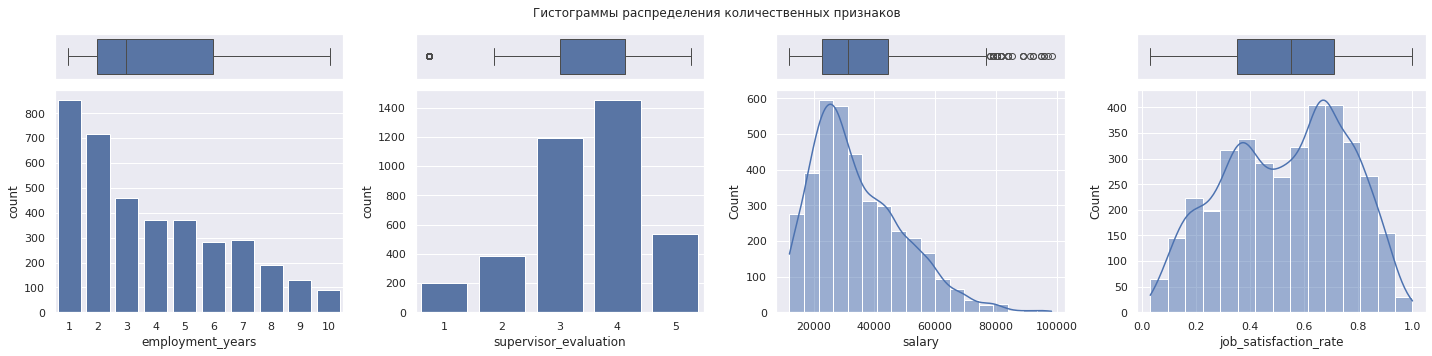

In [24]:
num_col_stats(
    train_job_satisfaction_rate,
    disc_features=['employment_years', 'supervisor_evaluation'],
    bins=[None, None, 18, 15]
)

Среди количественных переменных мы видим 2 дискретных (`employment_years` и `supervisor_evaluation`) и 2 непрерывных признака (`salary` и `job_satisfaction_rate`). Выбросы в данных, судя по боксплотам, есть в показателе оценки от руководителя (оценка 1) и в области высоких зарплат - оставим их. Интерес представляет распределение целевой переменной `job_satisfaction_rate` - оно представляет собой бимодальное распределение с первой модой 0.4 и второй модой 0.7. Данный показатель собирали непосредственно с форм обратной связи от сотрудников - получается сотрудники компании условно делятся на две группы: кто, в целом, доволен работой в компании и кто, в целом, не доволен - можно будет учесть в дальнейшем, при необходимости.

In [25]:
# напишем функцию для построения диаграмм рассеяния входных признаков с целевой переменной с учетом категориальных признаков
def scatter_plots_func(df, target, figsize=(15, 15)):
    
    # Создаем список количественных признаков
    num_features = df.select_dtypes(exclude=['object']).columns.tolist()
    
    # Создаем список категориальных признаков
    cat_features = df.select_dtypes(include=['object']).columns.tolist()
    
    # удаляем таргет из списков входных признаков
    if target in num_features:
        num_features.remove(target)
    elif target in cat_features:
        cat_features.remove(target)
    else:
        # вызываем исключение, если указанного таргета нет во фрейме 
        raise ValueError(f"{target} not in frame")
    
    # Создаем фигуру с подграфиками
    fig, axs = plt.subplots(len(cat_features), len(num_features), figsize=figsize)
    plt.suptitle(f"Диаграммы рассеяния целевого признака {target} и входных признаков\n", fontsize=16)
    
    # Итерируемся по строкам и столбцам для создания графиков рассеяния
    for i, j in product(range(len(cat_features)), range(len(num_features))):

        # настройка подграфиков для случаев с 1 категориальным или количественным признаком 
        if len(cat_features) == 1:
            ax = axs[j]
        elif len(num_features) == 1:
            ax = axs[i]
        else:
            ax = axs[i][j]
        
        # строем диаграмму
        sns.scatterplot(data=df, x=num_features[j], y=target, hue=cat_features[i], ax=ax, alpha=0.7)
        
        # настройка отображения элементов
        if j != len(num_features)-1:
            ax.legend().set_visible(False)
        if j != 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        if i != len(cat_features)-1:
            ax.set_xlabel('')
            ax.set_xticklabels([])
    
    # Регулируем расположение графиков
    plt.tight_layout()

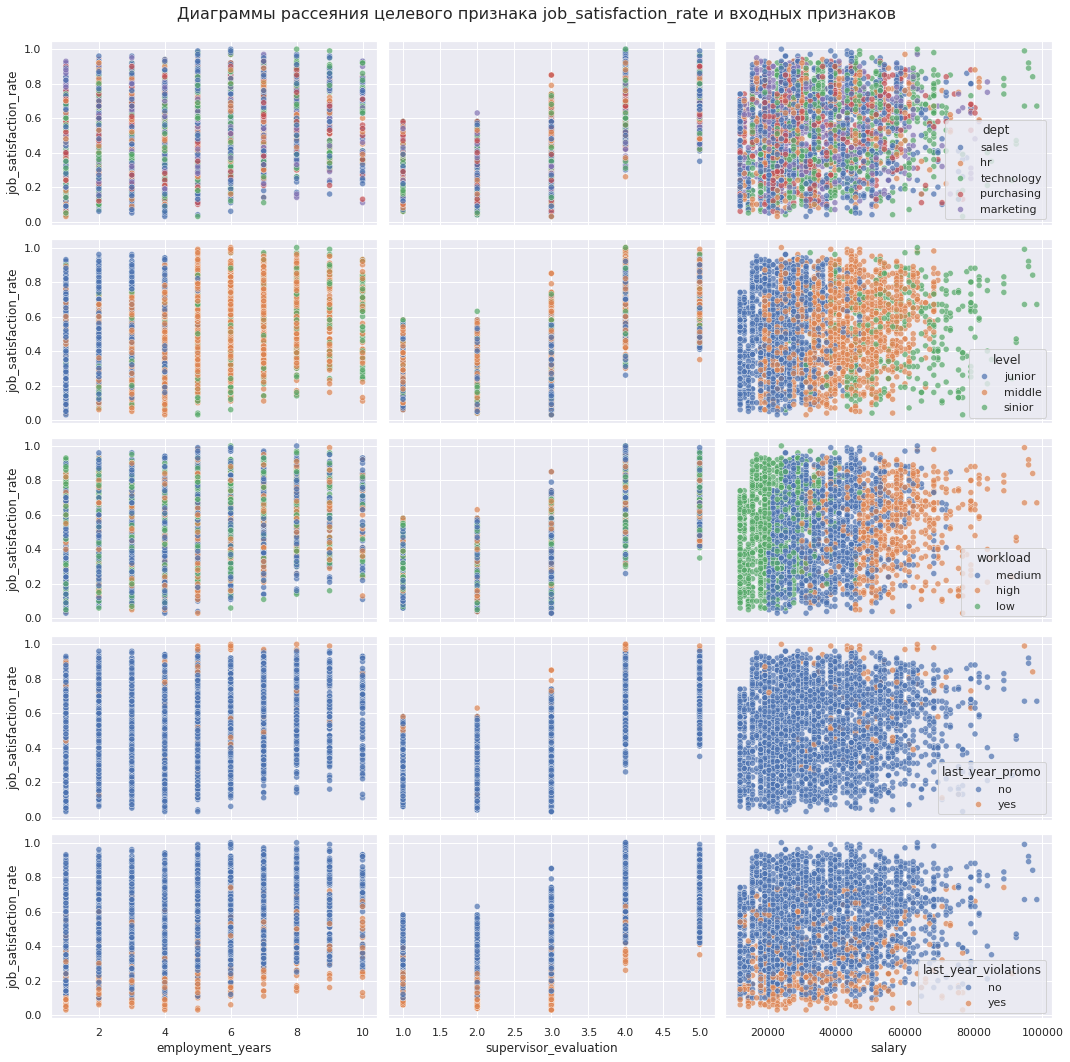

In [26]:
scatter_plots_func(train_job_satisfaction_rate, 'job_satisfaction_rate')

По данному графику однозначно можно сказать лишь то, что с целевой переменной есть линейная связь у признака `supervisor_evaluation`. Если говорить о категориальных переменных, то связь прослеживается у `last_year_promo` и `last_year_violations`.

Так как у нас тестовая выборка предоставлена заказчиком, то не будет лишним сравнить распределение тренировочной и тестовой выборок - если разделение на выборки было беспристрастным, то распределения должны +- совпадать.

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.00000
mean,3.666500,3.526500,34066.800000,0.54878
std,2.537222,0.996892,15398.436729,0.22011
min,1.000000,1.000000,12000.000000,0.03000
25%,1.000000,3.000000,22800.000000,0.38000
50%,3.000000,4.000000,30000.000000,0.58000
75%,6.000000,4.000000,43200.000000,0.72000
max,10.000000,5.000000,96000.000000,1.00000


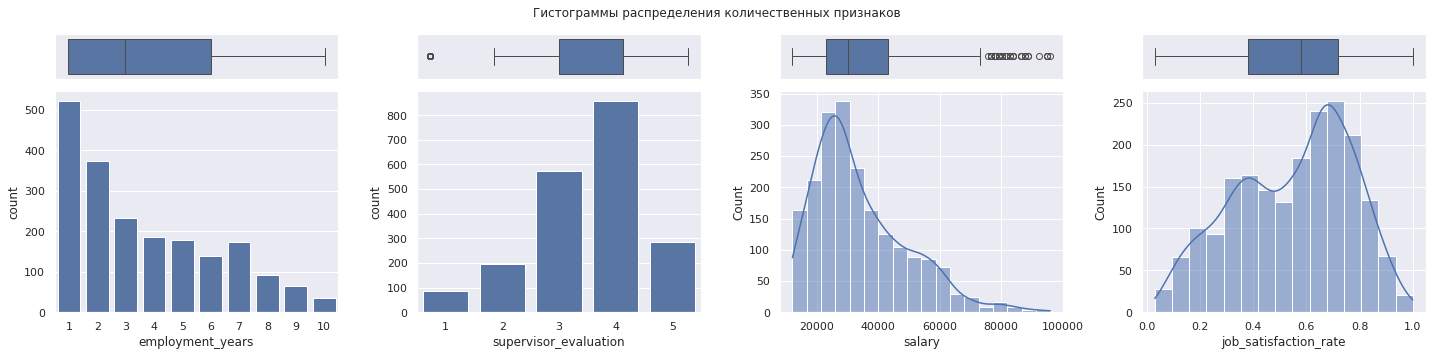

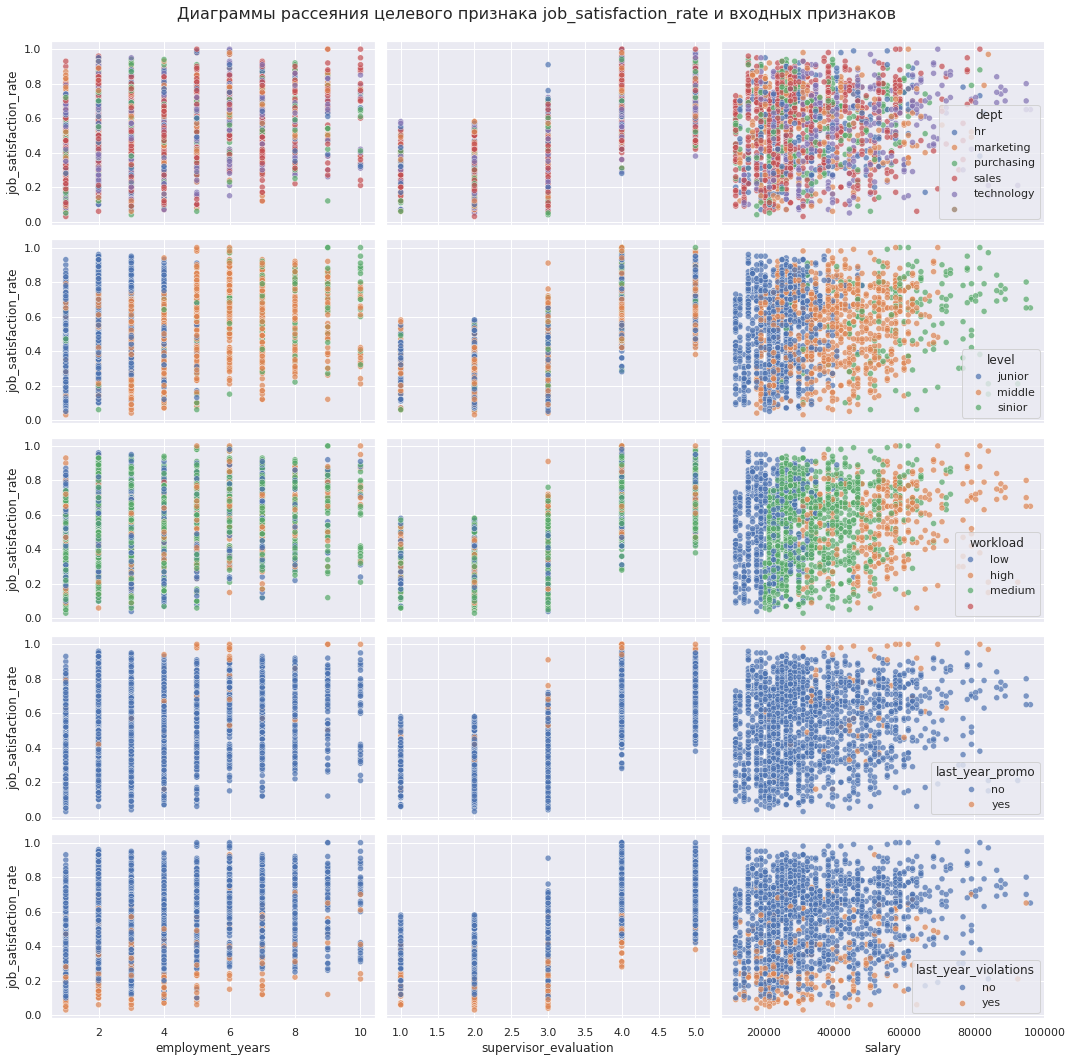

In [27]:
# выведем статистическую информацию и графики распределения для тестовой выборки
num_col_stats(
    test_features.join(test_target_job_satisfaction_rate),
    disc_features=['employment_years', 'supervisor_evaluation'],
    bins=[None, None, 18, 15]
)

# выведем диаграммы рассеяния для тестовой выборки
scatter_plots_func(test_features.join(test_target_job_satisfaction_rate), 'job_satisfaction_rate')

Судя по полученным графикам и цифрам, разделение на выборки было корректным.

#### Анализ качественных переменных

In [28]:
# напишем ф-ю для анализа качественных переменных
def cat_col_stats(df, nrows=2, figsize=(15, 8)):
    # записываем столбцы с качественными переменными 
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # строим столбчатые диаграммы распределения
    plt.figure(figsize=figsize)
    plt.suptitle('Диаграммы распределения качественных признаков\n', fontsize=16)
    for i, column in enumerate(cat_columns):
        plt.subplot(nrows, math.ceil(len(cat_columns) / nrows), i + 1)
        plt.title(column, fontsize=14)
        plt.pie(df[column].value_counts(), autopct='%.01f%%', labels=df[column].value_counts().index)

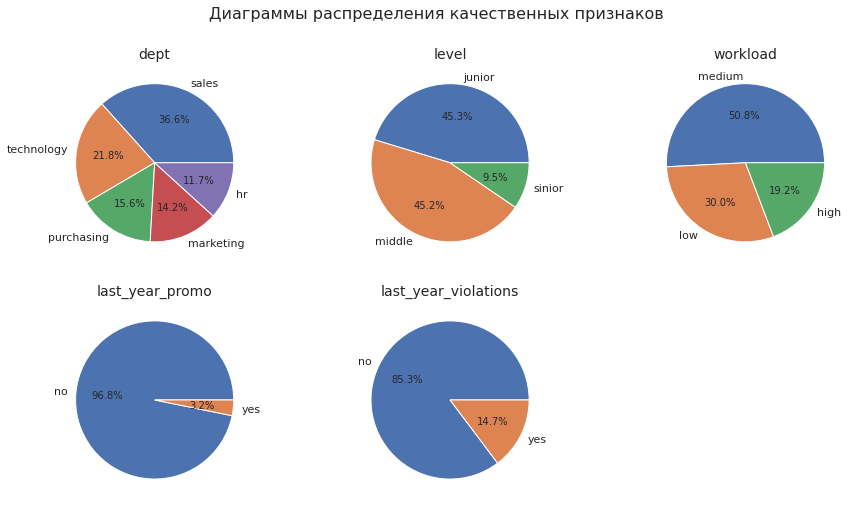

In [29]:
cat_col_stats(train_job_satisfaction_rate)

По диаграммам распределения качественных признаков можно сделать как минимум одно интересное наблюдение - среди 4000 сотрудников в предоставленном датасете 97% не повышали в должности за последний год. Либо в предоставленную выборку намеренно занесли данные только таких сотрудников, либо в компании что-то не так с карьерным ростом:) 

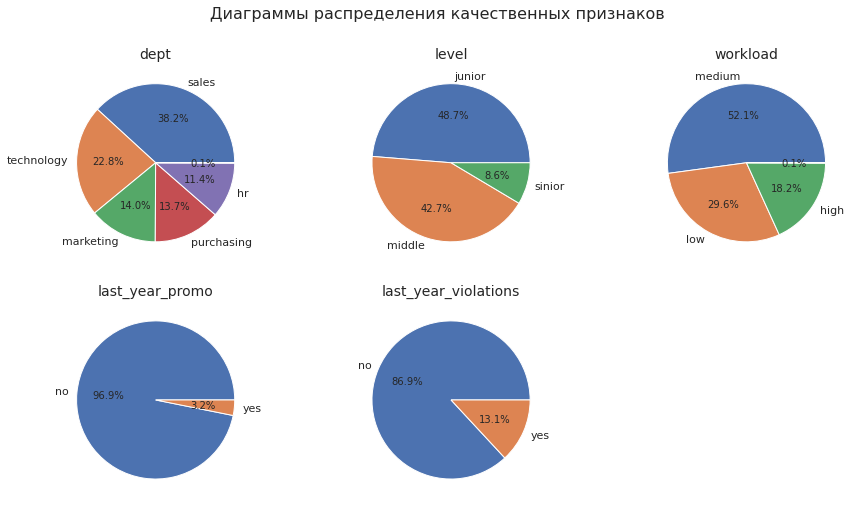

In [30]:
# посмотрим распределение в тестовой выборке
cat_col_stats(test_features.join(test_target_job_satisfaction_rate))

Распределение качественных признаков в тестовой выборке также соответствует распределению в тренировочной выборке. 

#### Корреляционный анализ

На данном этапе необходимо проследить взаимосвязи между признаками с помощью корреляционной матрицы. Для построения этих графиков напишем функцию `phik_matrix_heatmap`. В качестве коэффициента корреляции будем использовать фи-коэффициент, т.к. он позволяет проследить корреляцию как между количественными, так и между качественными переменными

In [31]:
def phik_matrix_heatmap(df, figsize=(10, 10)):
    # Корреляционноя матрица входных признаков и таргета
    df_phik = df.phik_matrix(interval_cols=df.select_dtypes(exclude=['object']).columns.tolist())

    plt.figure(figsize=figsize)
    sns.heatmap(df_phik, annot=True)
    plt.suptitle('Корреляционная матрица')
    plt.tight_layout();

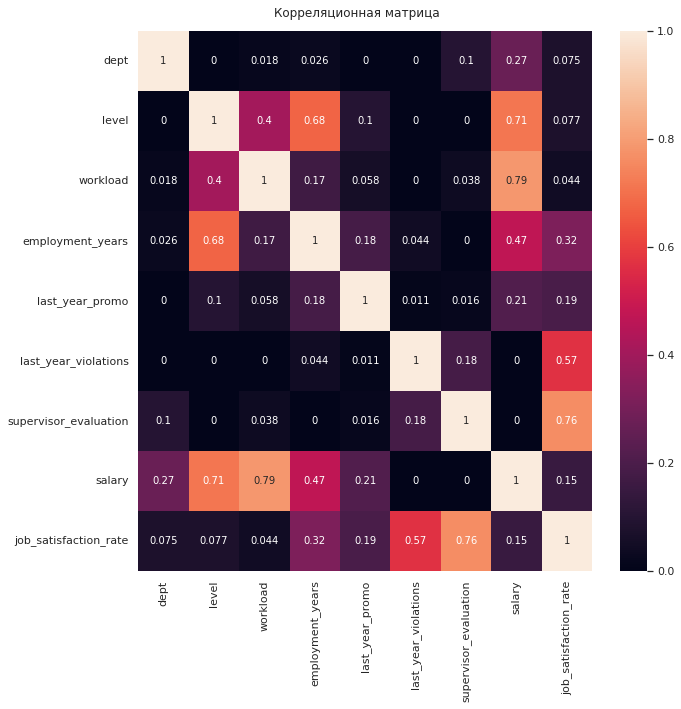

In [32]:
phik_matrix_heatmap(train_job_satisfaction_rate)

По корреляционной матрице можно сделать несколько выводов:
- с целевой переменной отсутствует/практически отсутствует корреляция у следующих признаков: `dept`, `level` и `workload` - удалять их пока не будем - потом посмотрим, как они влияют на модель;
- сильнее всего на целевую переменную влияет оценка качества работы сотрудника, которую дал руководитель - `supervisor_evaluation`;
- мультиколлинеарности не обнаружено - максимальный межпризнаковый коэффициент корреляции равен 0.79.

**Вывод:** в данном разделе был проведен исследовательский анализ данных, в результате которого было отмечено:
- среди количественных переменных мы видим 2 дискретных (`employment_years` и `supervisor_evaluation`) и 2 непрерывных признака (`salary` и `job_satisfaction_rate`);
- выбросы в данных, судя по боксплотам, есть в показателе оценки от руководителя (оценка 1) и в области высоких зарплат - решено их оставить;
- распределение целевой переменной `job_satisfaction_rate` является бимодальным с первой модой 0.4 и второй модой 0.7;
- распределение признаков в тестовой выборке соответствует распределению в тренировочной выборке, следовательно разделение на выборки было корректным;
- с целевой переменной отсутствует/практически отсутствует корреляция у следующих признаков: `dept`, `level` и `workload` - удалять их пока не будем - потом посмотрим, как они влияют на модель;
- сильнее всего на целевую переменную влияет оценка качества работы сотрудника, которую дал руководитель - `supervisor_evaluation`;
- мультиколлинеарности не обнаружено - максимальный межпризнаковый коэффициент корреляции равен 0.79.

### Подготовка данных

В данном разделе необходимо написать пайплайн для подготовки данных, включающий в себя масштабирование количественных признаков с помощью `StandardScaler()` и кодирование качественных признаков с помощью `OneHotEncoder()` и `OrdinalEncoder()`. В случае линейных моделей, кодирование будет проводится только методом OneHotEncoder (укажем это на этапе обучения), т.к. OrdinalEncoder не подходит для линейных моделей.  

In [33]:
# определим тренировочную и тестовую выборки
X_train = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = test_features
y_test = test_target_job_satisfaction_rate['job_satisfaction_rate']

In [34]:
# проверим размерности выборок
print(f"""Размерность тренировочной выборки:
      X_train - {X_train.shape}
      y_train - {y_train.shape}\n""")
print(f"""Размерность тестовой выборки:
      X_test - {X_test.shape}
      y_test - {y_test.shape}""")

Размерность тренировочной выборки:
      X_train - (3755, 8)
      y_train - (3755,)

Размерность тестовой выборки:
      X_test - (2000, 8)
      y_test - (2000,)


Среди качественных признаков у нас имеется несколько ранговых - `level`, `workload`, `last_year_promo` и `last_year_violations`. Их мы будем кодировать с п-ю `OrdinalEncoder()`, а оставшийся номинальный признак `dept` - с помощью `OneHotEncoder()`.

In [35]:
# задаем списки с названиями столбцов для соответствующего шага подготовки данных
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = X_train.select_dtypes(exclude='object').columns.to_list()

In [36]:
# создаем пайплайн для OrdinalEncoder (после кодирования заполняем пропуски с п-ю SimpleImputer)
ord_pipe = make_pipeline(
    OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high'],
            ['no', 'yes'],
            ['no', 'yes']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan
    ),
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')
)

# создаём общий пайплайн для подготовки данных
col_transform = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)],
    remainder='passthrough'
)

Пайплайн подготовки данных готов. Следует отметить, что в кодировщики были добавлены параметры, отвечающие за работу с неизвестными значениями признаков:
- для OrdinalEncoder были добавлены параметры `handle_unknown='use_encoded_value', unknown_value=np.nan` - теперь, если обученный кодировщик встретит неизвестное значение (например в новых тестовых данных, которые может предоставить бизнес), то они будут заменены пропусками (например в тестовой выборке у нас есть значение ' ' (пробел), которое заполнится пропуском), а затем все пропуски будут заполнены самым частым значением с помощью `SimpleImputer()`;
- для OneHotEncoder также добавлен параметр `handle_unknown='ignore'` - при встрече неизвестного значения, кодировщик его проигнорирует и не будет добавлять в признаковое пространство.

### Обучение моделей

В данном разделе необходимо обучить несколько моделей и выбрать лучшую из них. Оценивать качество моделей будем по метрике SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»):

$$\mathrm{SMAPE} = \frac {100} n \sum_{i=1}^n \frac{|y_i - \hat{y_i}|} {0.5 * (|y_i| + |\hat y_i|)}$$

Чтобы использовать данную метрику, необходимо написать функцию, реализующую механизм расчета метрики, а затем создать пользовательскую метрику с помощью `make_scorer()`.

In [37]:
# напишем функцию, реализующую расчет метрики SMAPE
def get_smape(y_true, y_pred):
    # преобразуем датафрейм y_true в numpy-массив
    y_true = y_true.to_numpy()
    
    # проверяем, что длина у y_true и y_pred одинаковая, иначе вызываем исключение
    if len(y_true) != len(y_pred):
        raise ValueError(
            f"Lengths of y_true and y_pred do not match ({len(y_true)} vs {len(y_pred)})"
        )
    
    numerator = np.abs(y_true - y_pred)
    denominator = 0.5 * (np.abs(y_true) + np.abs(y_pred))
    
    # перехватываем "деление на 0"
    denominator[denominator == 0] = 0.00000001
    
    div_array = numerator / denominator
    metric = np.sum(div_array) * 100 / len(y_true)
    
    return metric

Теперь создадим список моделей и диапазоны их гиперпараметров, в пределах которых мы будем искать лучшую модель. Подбор гиперпараметров будем делать с помощью GridSearchCV с кросс-валидацией.
Модели и диапазоны гиперпараметров:
1. `LinearRegression` - линейная регрессия;
2. `Lasso` - регрессия с l1-регуляризацией:
    - `alpha`: от 1 до 10;
3. `Ridge` - регрессия с l2-регуляризацией:
    - `alpha`: от 1 до 10;
4. `DecisionTreeRegressor` - дерево решений для регрессии:
    - `max_depth`: от 2 до 20;
    - `min_samples_leaf`: от 1 до 5;
    - `min_samples_split`: от 2 до 5.

Также нужно не забыть, что в линейных моделях нужно указать OHE-кодировку вместо OrdinalEncoder. 

In [38]:
# задаем список моделей
models = [
    LinearRegression(),
    Lasso(random_state=RANDOM_STATE),
    Ridge(random_state=RANDOM_STATE),
    DecisionTreeRegressor(random_state=RANDOM_STATE)
]

# задаем список словарей с диапазонами гиперпараметров моделей
params = [
    # параметры LinearRegression
    {
        'columntransformer__ord': [OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')]
    },
    
    # параметры Lasso
    {
        'lasso__alpha': range(1, 11),
        'columntransformer__ord': [OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')]
    },
    
    # параметры Ridge
    {
        'ridge__alpha': range(1, 11),
        'columntransformer__ord': [OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')]
    },
    
    # параметры DecisionTreeRegressor
    {
        'decisiontreeregressor__max_depth': range(2, 21),
        'decisiontreeregressor__min_samples_leaf': range(1, 6),
        'decisiontreeregressor__min_samples_split': range(2, 6)
    }
]

Теперь перейдем непосредственно к обучению моделей и оценке качества. Последовательность действий такая:
- в цикле проходимся по моделям, для каждой подбираем гиперпараметры и обучаем;
- результаты поиска для каждой модели сохраняем в словарь `search_dict`;
- добавляем результаты по модели в таблицу `models_smape`.

In [39]:
# создаем пустую таблицу для вывода результатов сравнения метрик моделей
models_smape = pd.DataFrame(columns=['model', 'parameters', 'SMAPE CV'])

# создаем пустой словарь для сохранения результатов поиска
search_dict = {}

# создаем пользовательскую метрику SMAPE
# (указываем greater_is_better=False, т.к. чем меньше метрика, тем лучше)
scorer = make_scorer(get_smape, greater_is_better=False)

# проходим в цикле по моделям
for i, model in enumerate(models):
    # создаем общий пайплайн
    pipe = make_pipeline(col_transform, model)
    # подбираем гиперпараметры модели
    gs = GridSearchCV(
        pipe,
        params[i],
        scoring=scorer,
        n_jobs=-1
    ).fit(X_train, y_train)
    
    # сохраняем результаты поиска в словарь
    search_dict[gs.best_estimator_[-1].__class__.__name__] = gs

# заполняем таблицу с результатами для каждой найденной модели
for key, gs in search_dict.items():
    models_smape.loc[len(models_smape)] = [
        key,
        gs.best_params_,
        gs.best_score_ * -1
    ]

# выводим таблицу с результатами
models_smape.sort_values(by='SMAPE CV')

,model,parameters,SMAPE CV
3,DecisionTreeRegressor,"{'decisiontreeregressor__max_depth': 19, 'deci...",15.282712
2,Ridge,{'columntransformer__ord': OneHotEncoder(drop=...,24.984995
0,LinearRegression,{'columntransformer__ord': OneHotEncoder(drop=...,24.996940
1,Lasso,{'columntransformer__ord': OneHotEncoder(drop=...,40.190265


Лучшая модель по метрике SMAPE - дерево решений DecisionTreeRegressor. У данной модели SMAPE на кросс-валидации равен 15.28.

In [40]:
# посмотрим модели DecisionTreeRegressor с другими наборами гиперпараметров
pd.DataFrame(search_dict['DecisionTreeRegressor'].cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_leaf,param_decisiontreeregressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
350,0.021703,0.000378,0.007042,0.000444,19,3,4,"{'decisiontreeregressor__max_depth': 19, 'deci...",-14.929225,-14.502296,-15.961490,-16.061741,-14.958808,-15.282712,0.617502,1
349,0.022870,0.002007,0.007026,0.000916,19,3,3,"{'decisiontreeregressor__max_depth': 19, 'deci...",-14.929225,-14.502296,-15.961490,-16.061741,-14.958808,-15.282712,0.617502,1
351,0.022328,0.000400,0.006936,0.000273,19,3,5,"{'decisiontreeregressor__max_depth': 19, 'deci...",-14.929225,-14.502296,-15.961490,-16.061741,-14.958808,-15.282712,0.617502,1
348,0.022335,0.000319,0.006945,0.000130,19,3,2,"{'decisiontreeregressor__max_depth': 19, 'deci...",-14.929225,-14.502296,-15.961490,-16.061741,-14.958808,-15.282712,0.617502,1
369,0.022041,0.001447,0.006895,0.000941,20,3,3,"{'decisiontreeregressor__max_depth': 20, 'deci...",-14.929225,-14.502296,-15.961490,-16.062301,-14.958808,-15.282824,0.617643,5
368,0.021336,0.000259,0.006754,0.000105,20,3,2,"{'decisiontreeregressor__max_depth': 20, 'deci...",-14.929225,-14.502296,-15.961490,-16.062301,-14.958808,-15.282824,0.617643,5
370,0.020611,0.000192,0.006236,0.000064,20,3,4,"{'decisiontreeregressor__max_depth': 20, 'deci...",-14.929225,-14.502296,-15.961490,-16.062301,-14.958808,-15.282824,0.617643,5
371,0.020860,0.000136,0.006203,0.000170,20,3,5,"{'decisiontreeregressor__max_depth': 20, 'deci...",-14.929225,-14.502296,-15.961490,-16.062301,-14.958808,-15.282824,0.617643,5
331,0.024205,0.002653,0.007043,0.000229,18,3,5,"{'decisiontreeregressor__max_depth': 18, 'deci...",-14.908779,-14.474333,-15.964082,-16.070785,-15.010309,-15.285658,0.624946,9
328,0.020930,0.000192,0.006467,0.000241,18,3,2,"{'decisiontreeregressor__max_depth': 18, 'deci...",-14.908779,-14.474333,-15.964082,-16.070785,-15.010309,-15.285658,0.624946,9


Лучшая модель найдена. Теперь посмотрим на метрику SMAPE на тестовой выборке.

In [41]:
# делаем прогноз на тестовой выборке
y_pred = search_dict['DecisionTreeRegressor'].predict(X_test)

# выводим значение метрики
print(f"SMAPE на тестовой выборке: {get_smape(y_test, y_pred)}")

SMAPE на тестовой выборке: 13.485222121375015


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


Метрика SMAPE на тестовой выборке равна 13.49. Согласно брифу:
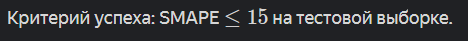

Необходимое качество достигнуто - выведем параметры найденной модели.

In [42]:
# выведем параметры лучшей модели
search_dict['DecisionTreeRegressor'].best_params_

{'decisiontreeregressor__max_depth': 19,
 'decisiontreeregressor__min_samples_leaf': 3,
 'decisiontreeregressor__min_samples_split': 2}

### Выводы по задаче

В результате поиска лучшей модели регрессии среди прочих, `DecisionTreeRegressor(max_depth=19, min_samples_leaf=3, random_state=42)` оказалась наилучшей в данной задаче. Это подтверждается показателем метрики SMAPE (Symmetric Mean Absolute Percentage Error) на кросс-валидации по тренировочной выборке 15.28. На тестовой выборке модель показала метрику 13.49, что удовлетворяет требованию брифа.
Лучшую метрику на модели `DecisionTreeRegressor` можно объяснить тем, что в данных имеются нелинейные зависимости, которые данная модель способна хорошо улавливать.

## Задача 2. Предсказание увольнения сотрудника из компании

Для этой задачи используются те же входные признаки, поменялся только целевой признак. Однако все равно еще раз пропишем описание признаков:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` - оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `quit` — увольнение сотрудника из компании, целевой признак.

### Загрузка данных

#### Получение наборов данных

In [43]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except FileNotFoundError:
    train_quit = pd.read_csv('datasets/train_quit.csv')
    test_features = pd.read_csv('datasets/test_features.csv')
    test_target_quit = pd.read_csv('datasets/test_target_quit.csv')

#### Изучение информации о датасетах

In [44]:
# выведем основную информацию о датасетах с помощью словаря и функции datasets_overview 
datasets_dict = {
    'train_quit': train_quit,
    'test_features': test_features,
    'test_target_quit': test_target_quit
}       

datasets_overview(datasets_dict)

Информация о датафреймах:

train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------

test_target_quit:


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

Найдено строк-дубликатов: 0
------------------------------------------------------------



**Вывод:** В качестве исходных данных у нас имеется 3 таблицы, предварительный анализ которых позволил выделить следующее:

1. `test_features`:
    - Имена столбцов приведены корректно;
    - Типы данных указаны верно;
    - Полных дубликатов строк не обнаружено;
    - Обнаружены пропуски в столбцах `dept` и `level`.

2. `train_quit`, `test_target_quit`:
    - Имена столбцов приведены корректно;
    - Типы данных указаны верно;
    - Полных дубликатов строк и пропусков не обнаружено.

### Предобработка данных

Ход действий в предобработке аналогичен первой задаче: неявные дубликаты => ошибки-разночтения => установка `id` в качестве индексов => удаление дубликатов. Также проведем необходимые проверки выборок.

#### Проверка на неявные дубликаты

In [45]:
# проверяем на неявные дубликаты
print(f"""\
Количество неявных дубликатов в train_quit: {train_quit.duplicated(subset='id').sum()}
Количество неявных дубликатов в test_features: {test_features.duplicated(subset='id').sum()}
Количество неявных дубликатов в test_target_quit: {test_target_quit.duplicated(subset='id').sum()}
""")

Количество неявных дубликатов в train_quit: 0
Количество неявных дубликатов в test_features: 0
Количество неявных дубликатов в test_target_quit: 0



#### Проверка уникальных значений в категориальных переменных

In [46]:
cat_col_unique(datasets_dict)

train_quit:
	dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
	level: ['middle' 'junior' 'sinior']
	workload: ['high' 'medium' 'low']
	last_year_promo: ['no' 'yes']
	last_year_violations: ['no' 'yes']
	quit: ['no' 'yes']
-----
test_features:
	dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
	level: ['junior' 'middle' 'sinior' nan]
	workload: ['medium' 'low' 'high' ' ']
	last_year_promo: ['no' 'yes']
	last_year_violations: ['no' 'yes']
-----
test_target_quit:
	quit: ['yes' 'no']
-----


Как и в первой задаче, ошибок-разночтений в данных нет. 

Также, как и в первой задаче, пропуски-пробелы и пропуски nan в `test_features` будут обработаны в пайплайне подготовки данных и обучения модели. По стратегии заполнение все тоже самое - самым частым значением соответствующего признака.

Теперь делаем необходимые проверки на корректность разбиения тренировочной и тестовой выборок, а также устанавливаем `id` в качестве индексов (в случае с тестовой выборкой - с сортировкой). 

In [49]:
# проверим все ли id в тестовой выборке входных признаков есть в таблице с целевой переменной для тестовой выборки
if set(test_target_quit['id']) == set(test_features['id']):
    print('id совпадают')
else:
    print('id не совпадают')

# проверим не пересекаются ли данные в тренировочной и тестовой выборках
if len(set(train_quit['id']) & set(test_features['id'])) == 0:
    print('Данные не пересекаются')
else:
    print('Данные пересекаются')

id совпадают
Данные не пересекаются


In [50]:
# устанавливаем id в качестве индексов и сортируем по индексу тестовую выборку
train_quit = train_quit.set_index('id')
test_features = test_features.set_index('id').sort_index()
test_target_quit = test_target_quit.set_index('id').sort_index()

display(train_quit.head(), test_features.head(), test_target_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


In [51]:
# еще раз проверяем таблицы на полные дубликаты
print(f"""\
Количество полных дубликатов в train_quit: {train_quit.duplicated().sum()}""")

Количество полных дубликатов в train_quit: 1413


Дубликатов очень много. Но тем не менее, придется их удалить, т.к. это одинаковые, с точки зрения обучения модели, данные.

In [52]:
# удаляем дубликаты
train_quit = train_quit.drop_duplicates()

# проверяем
print(f"Количество полных дубликатов в train_quit: {train_quit.duplicated().sum()}\n")
train_quit.info()

Количество полных дубликатов в train_quit: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 723290 to 692133
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2587 non-null   object
 1   level                  2587 non-null   object
 2   workload               2587 non-null   object
 3   employment_years       2587 non-null   int64 
 4   last_year_promo        2587 non-null   object
 5   last_year_violations   2587 non-null   object
 6   supervisor_evaluation  2587 non-null   int64 
 7   salary                 2587 non-null   int64 
 8   quit                   2587 non-null   object
dtypes: int64(3), object(6)
memory usage: 202.1+ KB


**Вывод:** в данном разделе была проведена предобработка данных, а именно проведены проверки на неявные дубликаты, ошибки-разночтения в категориальных переменных и удалены дубликаты в тренировочном фрейме, возникшие при установке `id` в качестве индексов датафреймов.

### Исследовательский анализ данных

#### Анализ количественных переменных

,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308
std,2.601105,1.080243,16267.354906
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,24000.000000
50%,4.000000,3.000000,33600.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


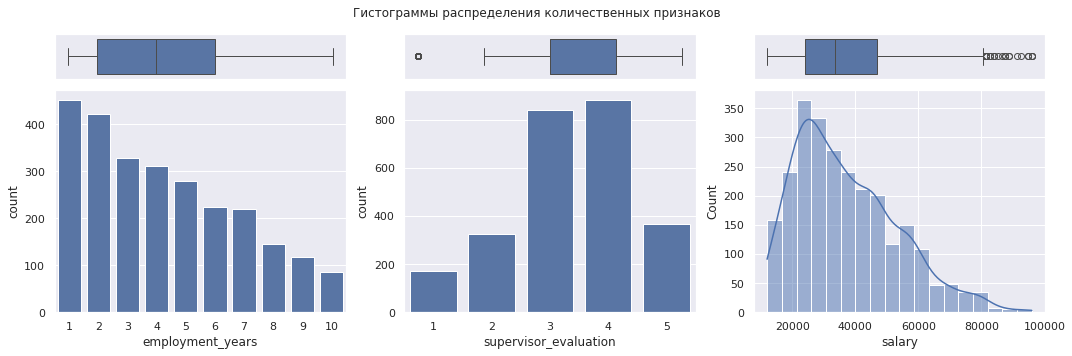

In [53]:
# выведем статистическую информацию по количественным признакам с помощью функции num_col_stats
num_col_stats(
    train_quit,
    disc_features=['employment_years', 'supervisor_evaluation'],
    bins=[None, None, 18],
    figsize=(15, 5)
)

Характер распределения количественных признаках в тренировочной выборке такой же, как в первой задаче, поэтому можно не сравнивать с тестовой, т.к. она та же, что и была.

#### Анализ качественных переменных

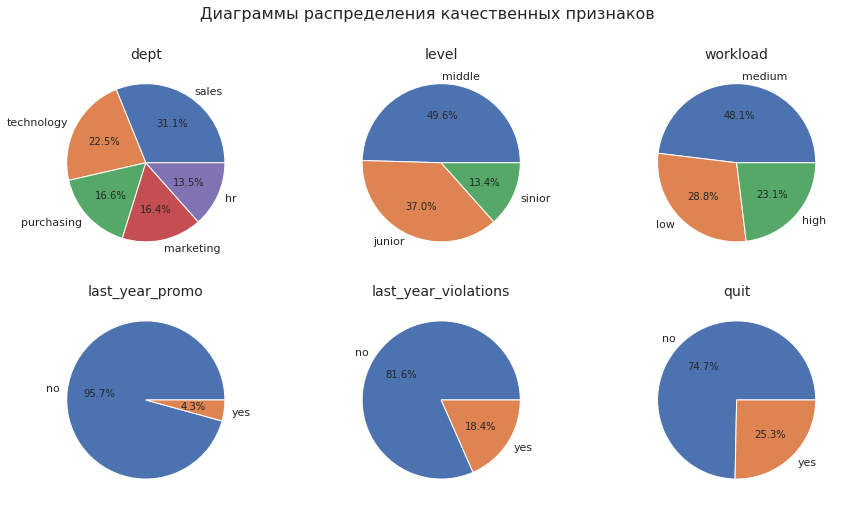

In [54]:
# построим диаграммы распределения качественных признаков тренировочной выборки
cat_col_stats(train_quit)

Распределение в качественных признаках также аналогично первой задаче. Однако по представленному графику можно наблюдать дисбаланс классов в целевом признаке `quit` - объектов класса `no` в 3 раза больше, чем `yes` - учтем это в дальнейшем, при обучении моделей.

#### Корреляционный анализ

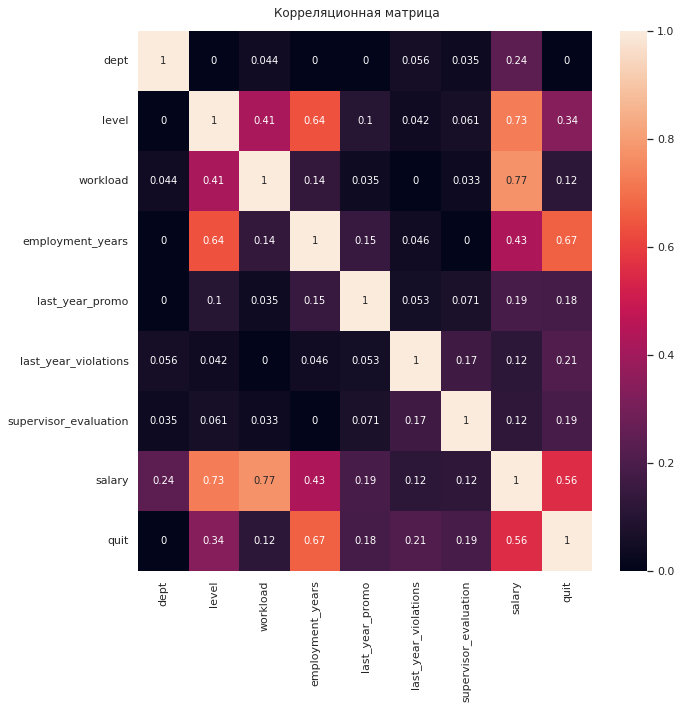

In [55]:
phik_matrix_heatmap(train_quit)

По корреляционной матрице можно сделать несколько выводов:
- с целевой переменной отсутствует корреляция у признака `dept` - удалять его также пока не будем;
- сильнее всего на целевую переменную влияет длительность работы в компании - `employment_years`;
- мультиколлинеарности не обнаружено - максимальный межпризнаковый коэффициент корреляции равен 0.77.

#### Составление портрета уволившегося сотрудника

Чтобы составить портрет уволившегося сотрудника, нужно проанализировать статистическую информацию и графики для уволившихся и оставшихся сотрудников. Построим столбчатые диаграммы, отражающие долю уволившихся и оставшихся сотрудников для каждого значения каждого признака.

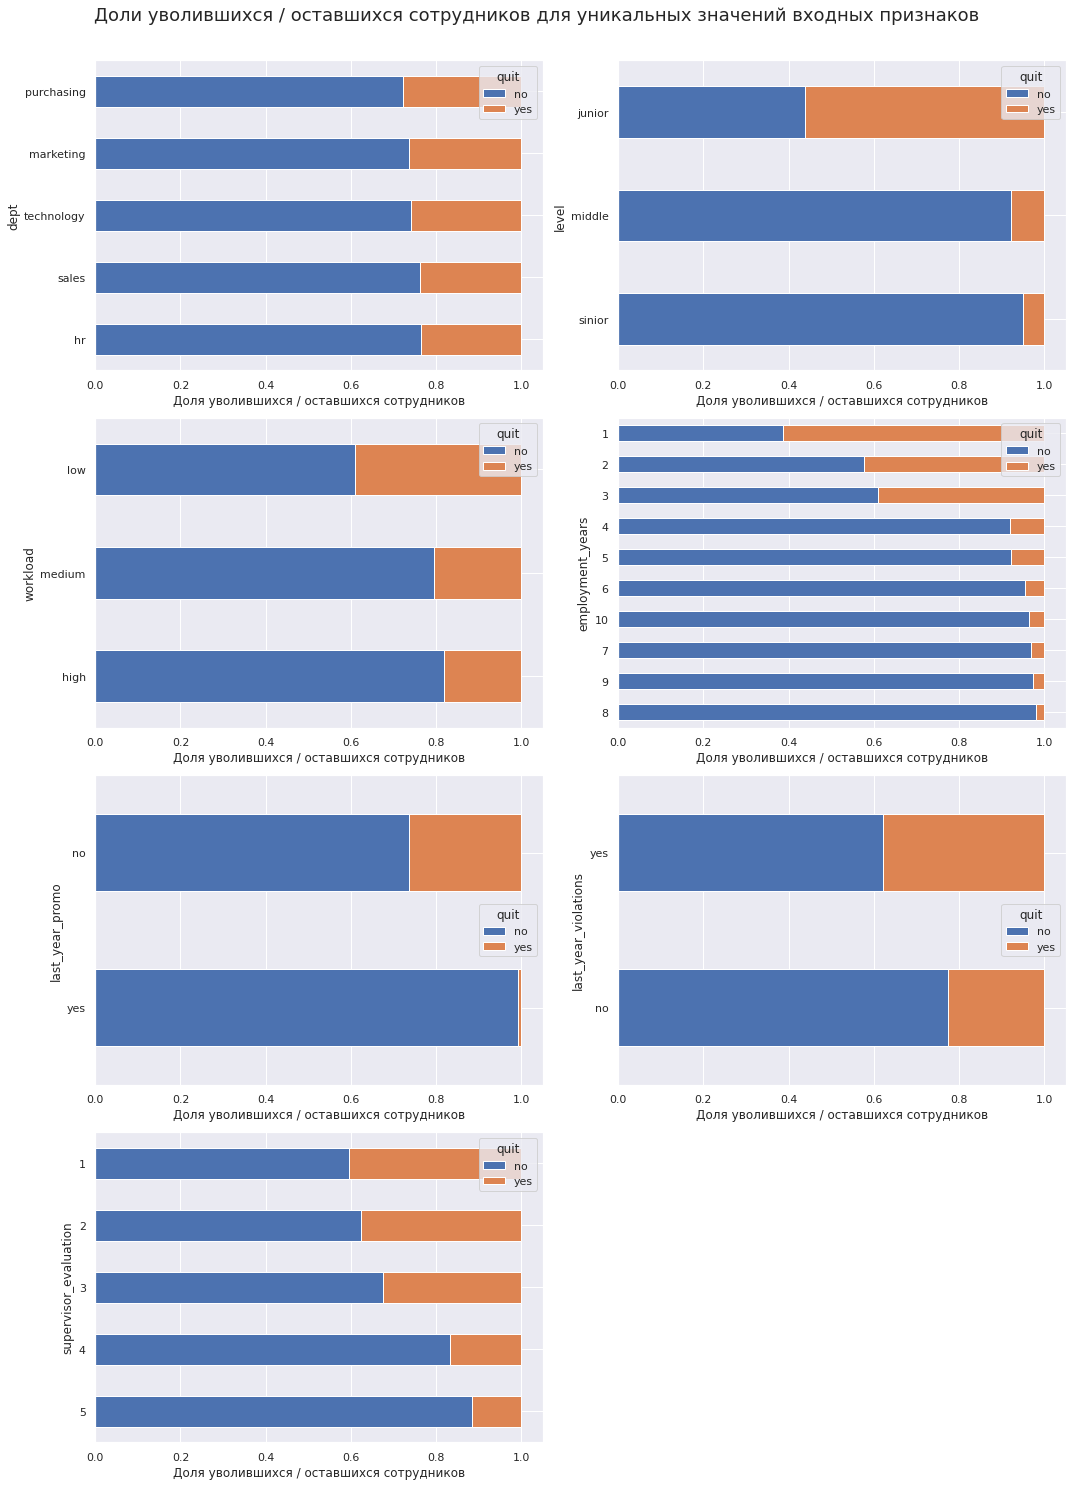

In [58]:
## строим стобчатые диаграммы, отражающие долю уволившихся и оставшихся сотрудников для каждого значения каждого признака
plt.figure(figsize=(15, 20))

# проходим в цикле по столбцам (исключая непрерывный признак salary и целевой quit)
for i, col in enumerate(train_quit.columns[:-2]):
    
    ax = plt.subplot(4, 2, i+1)
    
    # группируем по признаку col -> находим доли уволившихся и оставшихся -> сортируем и строим диаграмму 
    train_quit.groupby(col)['quit']\
    .value_counts(normalize=True).unstack('quit')\
    .sort_values(by='yes')\
    .plot(kind='barh', stacked=True, ax=ax)
    
    ax.set_xlabel('Доля уволившихся / оставшихся сотрудников')

plt.tight_layout()
plt.suptitle('Доли уволившихся / оставшихся сотрудников для уникальных значений входных признаков', y=1.03, fontsize=18);

Сделаем несколько выводов:
- Чаще сотрудники увольняются из отдела закупок, текучка в других отделах чуть меньше;
- Среди джунов текучка в несколько раз сильнее, чем у мидлов и синиоров;
- Чаще увольняются сотрудники с низкой загруженностью;
- У сотрудников с небольшим опытом - менее 3 лет - текучка в несколько раз выше;
- Среди тех, кто получал повышение за последний год, практически нет уволившихся;
- Доля уволившихся среди тех, кто нарушал трудовой договор, почти в 2 раза больше, чем среди остальных;
- Чем меньше оценка руководителя, тем чаще такие сотрудники увольняются.

Посмотрим на сравнение зарплат.

Медианная зарплата уволившихся сотрудников: 24000.0
Медианная зарплата оставшихся сотрудников: 39000.0


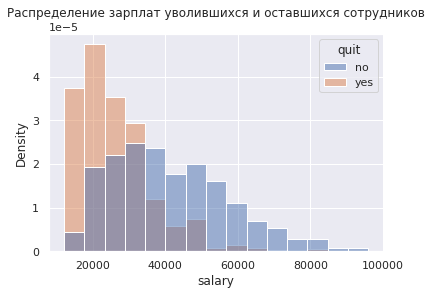

In [60]:
print(f"Медианная зарплата уволившихся сотрудников: {train_quit[train_quit['quit'] == 'yes'].salary.median()}")
print(f"Медианная зарплата оставшихся сотрудников: {train_quit[train_quit['quit'] == 'no'].salary.median()}")

sns.histplot(data=train_quit, x='salary', hue='quit', bins=15, stat='density', common_norm=False)
plt.title('Распределение зарплат уволившихся и оставшихся сотрудников');

Как можно заметить, действительно медианная зарплата у уволившихся меньше в 1.5 раза. Однако это объясняется тем, что увольняются менее опытные сотрудники - джуны. Среди оставшихся преобладают мидлы, поэтому и медианная зарплата выше. Посмотрим на такую же гистограмму, но для среза по джунам. 

Медианная зарплата уволившихся сотрудников-джунов: 22800.0
Медианная зарплата оставшихся сотрудников-джунов: 25200.0


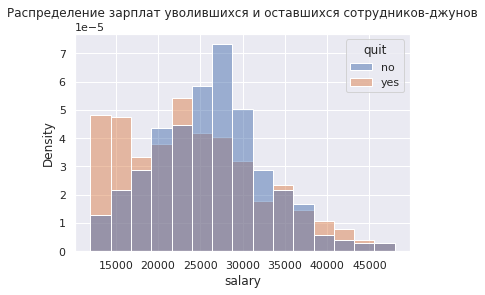

In [62]:
print(f"""Медианная зарплата уволившихся сотрудников-джунов: {
train_quit.loc[(train_quit['quit'] == 'yes') & ((train_quit['level'] == 'junior'))].salary.median()
}""")
print(f"""Медианная зарплата оставшихся сотрудников-джунов: {
train_quit.loc[(train_quit['quit'] == 'no') & ((train_quit['level'] == 'junior'))].salary.median()
}""")

sns.histplot(data=train_quit.query('level == "junior"'), x='salary', hue='quit', bins=15, stat='density', common_norm=False)
plt.title('Распределение зарплат уволившихся и оставшихся сотрудников-джунов');

Верный срез выбран и теперь можно скорректировать вывод - уволившиеся джуны получали на 18% меньше, чем оставшиеся.

Теперь можно составить портрет уволившегося сотрудника:
- мог работать в любом отделе, однако чуть более вероятнее - в отделе закупок;
- джун, с опытом работы в компании менее 3 лет;
- с низкой загруженностью;
- получал меньше, чем оставшиеся сотрудники (для джунов разница в 18%);
- получил низкую оценку работы от руководителя;
- не получал повышение за последний год;
- возможно, нарушал за последний год трудовой договор.

#### Анализ влияния уровня удовлетворенности сотрудника на вероятность увольнения

In [63]:
# проверим, совпадают ли сотрудники в таблицах с необходимыми данными
all(test_target_job_satisfaction_rate.index == test_target_quit.index)

True

In [64]:
# объединим таблицы с целевыми признаками
satisfaction_rate_and_quit = test_target_job_satisfaction_rate.join(test_target_quit)
satisfaction_rate_and_quit.sample(10)

,job_satisfaction_rate,quit
id,,
656844,0.68,no
314685,0.77,no
722322,0.49,no
330825,0.28,no
601062,0.88,no
818699,0.46,no
606269,0.67,no
212048,0.17,yes
810757,0.60,no


,Остался,Уволился
count,1436.000000,564.000000
mean,0.612040,0.387713
std,0.199367,0.185784
min,0.030000,0.040000
25%,0.500000,0.240000
50%,0.660000,0.370000
75%,0.760000,0.492500
max,1.000000,0.970000


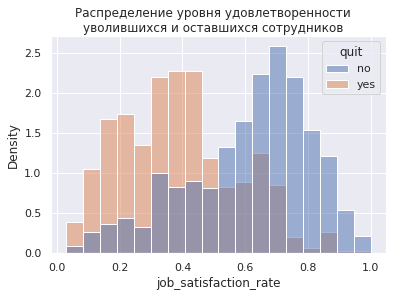

In [66]:
# создадим и выведем таблицу со статистической информацией об уровне
# удовлетворенности для уволившихся и оставшихся сотрудников
describe_table = pd.concat([satisfaction_rate_and_quit.query('quit == "no"').describe(),
           satisfaction_rate_and_quit.query('quit == "yes"').describe()], axis=1)
describe_table.columns = ['Остался', 'Уволился']
display(describe_table)

# строим гистограмму распределения
sns.histplot(
    data=test_target_job_satisfaction_rate.join(test_target_quit),
    x='job_satisfaction_rate',
    hue='quit',
    stat='density',
    common_norm=False
)
plt.suptitle('Распределение уровня удовлетворенности\nуволившихся и оставшихся сотрудников');

Судя по полученным данным, уволившиеся сотрудники действительно были сильнее неудовлетворены работой в компании, чем оставшиеся. Их медианный уровень удовлетворенности равен 0.37 против 0.66 у оставшихся сотрудников. 

**Вывод:** в данном разделе был проведен исследовательский анализ данных, в результате которого можно сделать следующие выводы:
- Характер распределения количественных и качественных признаков аналогичен данным из первой задачи;
- Выявлен дисбаланс классов в целевом признаке quit - объектов класса `no` в 3 раза больше, чем `yes`;
- С целевой переменной отсутствует корреляция у признака `dept` - удалять его также пока не будем;
- Сильнее всего на целевую переменную влияет длительность работы в компании - `employment_years`;
- Мультиколлинеарность не обнаружена - максимальный межпризнаковый коэффициент корреляции равен 0.77.

Также был составлен портрет уволившегося сотрудника:
- мог работать в любом отделе, однако чуть более вероятнее - в отделе закупок;
- джун, с опытом работы в компании менее 3 лет;
- с низкой загруженностью;
- получал меньше, чем оставшиеся сотрудники (для джунов разница в 18%);
- получил низкую оценку работы от руководителя;
- не получал повышение за последний год;
- возможно, нарушал за последний год трудовой договор.

В рамках данного анализа также было проверено утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. В результате выяснилось, что уволившиеся сотрудники действительно были сильнее неудовлетворены работой в компании, чем оставшиеся. Их медианный уровень удовлетворенности равен 0.37 против 0.66 у оставшихся сотрудников.

### Добавление нового входного признака

In [68]:
# добавляем предсказанное значение job_satisfaction_rate в датасет с тренировочной выборкой для данной задачи
train_quit['job_satisfaction_rate'] = search_dict['DecisionTreeRegressor'].predict(train_quit.drop('quit', axis=1))

# добавляем предсказанное значение job_satisfaction_rate в датасет с тестовой выборкой для данной задачи
test_features['job_satisfaction_rate'] = search_dict['DecisionTreeRegressor'].predict(test_features)

display(train_quit.head(), test_features.head())

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.605000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.337500
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.83125
100480,marketing,junior,low,4,no,no,4,16800,0.85200
100503,purchasing,middle,high,5,no,no,4,55200,0.81750
100610,sales,middle,medium,5,no,no,4,43200,0.81400
100692,sales,middle,high,6,no,no,4,48000,0.69600


### Подготовка данных

В данном разделе необходимо написать пайплайн для подготовки данных, аналогично первой задаче. Однако, т.к. у нас не поменялись ранговые переменные, то можно использовать пайплайн подготовки данных `col_transform` из первой задачи, только нужно заново определить список количественных признаков, т.к. мы добавили признак `job_satisfaction_rate`, и повторно инициировать `col_transform`, чтобы новый признак тоже обработался (если этого не сделать, то из-за параметра `remainder='passthrough'`, этот признак будет пропущен).

In [71]:
# определим тренировочную и тестовую выборки
X_train = train_quit.drop('quit', axis=1)
y_train = train_quit['quit']
X_test = test_features
y_test = test_target_quit['quit']

# кодируем целевую переменную с помощью LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

display(X_train.head(), y_train, X_test.head(), y_test)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.605000
814010,sales,junior,medium,2,no,no,4,27600,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,0.337500
257132,sales,junior,medium,2,no,yes,3,24000,0.350000
910140,marketing,junior,medium,2,no,no,5,25200,0.791667


array([0, 0, 0, ..., 1, 1, 0])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.83125
100480,marketing,junior,low,4,no,no,4,16800,0.85200
100503,purchasing,middle,high,5,no,no,4,55200,0.81750
100610,sales,middle,medium,5,no,no,4,43200,0.81400
100692,sales,middle,high,6,no,no,4,48000,0.69600


array([0, 0, 0, ..., 1, 0, 1])

In [72]:
# проверим размерности выборок
print(f"""Размерность тренировочной выборки:
      X_train - {X_train.shape}
      y_train - {y_train.shape}\n""")
print(f"""Размерность тестовой выборки:
      X_test - {X_test.shape}
      y_test - {y_test.shape}""")

Размерность тренировочной выборки:
      X_train - (2587, 9)
      y_train - (2587,)

Размерность тестовой выборки:
      X_test - (2000, 9)
      y_test - (2000,)


In [73]:
# проверим кодировку целевой переменной и еще раз удостоверимся в дисбалансе классов
pd.DataFrame(
    zip(label_encoder.inverse_transform(y_train), y_train),
    columns=['Целевой признак', 'Кодированное значение']
).value_counts()

Целевой признак  Кодированное значение
no               0                        1932
yes              1                         655
dtype: int64

In [74]:
# сохраняем новый список количественных признаков
num_columns = X_train.select_dtypes(exclude='object').columns.tolist()

print(ohe_columns, ord_columns, num_columns)

['dept'] ['level', 'workload', 'last_year_promo', 'last_year_violations'] ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [75]:
# заново инициируем общий пайплайн для подготовки данных
col_transform = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)],
    remainder='passthrough'
)

### Обучение модели

На данном этапе мы будем обучать модели классификации с подбором гиперпараметров и выбором лучшей модели по метрике ROC-AUC. Для этого нам также, как и в первой задаче, необходимо задать список моделей и диапазоны их гиперпараметров, в пределах которых мы будем искать лучшую модель. Подбор гиперпараметров будем делать с помощью RandomizedSearchCV с кросс-валидацией. Также, где это возможно, применим взвешивание классов.

Модели и диапазоны гиперпараметров:
1. `LogisticRegression()`:
    - регуляризация `l1` и `l2`;
    - `С`: от 1 до 5.
2. `KNeighborsClassifier()`:
    - `n_neighbors`: от 2 до 15.
3. `SVC()`:
    - `kernel`: `rbf`, `sigmoid` и `poly`;
    - `C`: от 1 до 5;
    - `γ`: от 1 до 5.
4. `DecisionTreeClassifier()`:
    - `max_depth`: от 2 до 20;
    - `min_samples_leaf`: от 1 до 10;
    - `min_samples_split`: от 2 до 10.

Также нужно не забыть, что в линейных моделях нужно указать OHE-кодировку вместо OrdinalEncoder. 

In [76]:
# задаем список моделей (в SVC указываем `probability=True`, чтобы можно было посчитать вероятности с п-ю .predict_proba())
models = [
    LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced'),
    KNeighborsClassifier(),
    SVC(random_state=RANDOM_STATE, probability=True, class_weight='balanced'), 
    DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
]

# задаем список словарей с диапазонами гиперпараметров моделей
params = [
    # параметры LogisticRegression
    {
        'logisticregression__penalty': ['l1', 'l2'],
        'logisticregression__C': range(1, 6),
        'columntransformer__ord': [OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')]
    },
    
    # параметры kNN
    {
        'kneighborsclassifier__n_neighbors': range(2, 16)
    },
    
    # параметры SVC
    {
        'svc__kernel': ['rbf', 'sigmoid', 'poly'],
        'svc__C': range(1, 5),
        'svc__gamma': range(1, 5)
    },
    
    # параметры DecisionTreeClassifier
    {
        'decisiontreeclassifier__max_depth': range(2, 21),
        'decisiontreeclassifier__min_samples_leaf': range(1, 11),
        'decisiontreeclassifier__min_samples_split': range(2, 11)
    }
]

Последовательность выбора лучшей модели аналогична первой задаче:
- в цикле проходимся по моделям, для каждой подбираем гиперпараметры и обучаем;
- результаты поиска для каждой модели сохраняем в словарь `class_search_dict`;
- добавляем результаты по модели в таблицу `models_roc`.

Помимо основной метрики ROC-AUC будем контролировать метрику Recall, по которой можно определить, как часто модель дает ложноотрицательные прогнозы класса (т.е. модель предсказала, что сотрудник не уволится, а он уволился). Это важно, т.к. бизнесу нужно в первую очередь знать кто из сотрудников уволится, чтобы лучше контролировать отток персонала.

In [77]:
# создаем пустую таблицу для вывода результатов сравнения метрик моделей
models_roc = pd.DataFrame(columns=['model', 'parameters', 'ROC-AUC CV', 'Recall CV'])

# создаем пустой словарь для сохранения результатов поиска
class_search_dict = {}

# задаем словарь с метриками для мультискорринга
scoring = {
    'roc_auc_score': 'roc_auc',
    'recall_score': 'recall'
}

# проходим в цикле по моделям
for i, model in enumerate(models):
    # создаем общий пайплайн
    pipe = make_pipeline(col_transform, model)
    # подбираем гиперпараметры модели
    rs = RandomizedSearchCV(
        pipe,
        params[i],
        scoring=scoring,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        refit='roc_auc_score'
    ).fit(X_train, y_train)
    
    # сохраняем результаты поиска в словарь
    class_search_dict[rs.best_estimator_[-1].__class__.__name__] = rs

# заполняем таблицу с результатами для каждой найденной модели
for key, rs in class_search_dict.items():
    models_roc.loc[len(models_roc)] = [
        key,
        rs.best_params_,
        rs.best_score_,
        pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_roc_auc_score')['mean_test_recall_score'].iloc[0]
    ]

# выводим таблицу с результатами
models_roc.sort_values(by='ROC-AUC CV', ascending=False)

,model,parameters,ROC-AUC CV,Recall CV
0,LogisticRegression,"{'logisticregression__penalty': 'l2', 'logisti...",0.911413,0.876336
1,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 15},0.903444,0.697710
3,DecisionTreeClassifier,{'decisiontreeclassifier__min_samples_split': ...,0.896019,0.838168
2,SVC,"{'svc__kernel': 'poly', 'svc__gamma': 1, 'svc_...",0.886394,0.804580


Лучшей моделью оказалась логистическая регрессия: значение ROC-AUC на кросс-валидации 0.91, а recall - 0.88.

In [78]:
# посмотрим метрики моделей LogisticRegression с другими наборами гиперпараметров
pd.DataFrame(class_search_dict['LogisticRegression'].cv_results_).sort_values(by='rank_test_roc_auc_score')[[
    'params',
    'mean_test_roc_auc_score',
    'std_test_roc_auc_score',
    'rank_test_roc_auc_score',
    'mean_test_recall_score',
    'std_test_recall_score',
    'rank_test_recall_score'
    
]]

,params,mean_test_roc_auc_score,std_test_roc_auc_score,rank_test_roc_auc_score,mean_test_recall_score,std_test_recall_score,rank_test_recall_score
1,"{'logisticregression__penalty': 'l2', 'logisti...",0.911413,0.012569,1,0.876336,0.027481,1
3,"{'logisticregression__penalty': 'l2', 'logisti...",0.911377,0.012531,2,0.874809,0.027566,7
8,"{'logisticregression__penalty': 'l1', 'logisti...",0.911357,0.012315,3,0.876336,0.027481,1
6,"{'logisticregression__penalty': 'l1', 'logisti...",0.911353,0.012336,4,0.876336,0.027481,1
9,"{'logisticregression__penalty': 'l2', 'logisti...",0.911337,0.012464,5,0.874809,0.027566,7
5,"{'logisticregression__penalty': 'l2', 'logisti...",0.911333,0.012516,6,0.874809,0.027566,7
4,"{'logisticregression__penalty': 'l1', 'logisti...",0.911329,0.012355,7,0.876336,0.027481,1
7,"{'logisticregression__penalty': 'l2', 'logisti...",0.911313,0.012466,8,0.874809,0.027566,7
2,"{'logisticregression__penalty': 'l1', 'logisti...",0.911294,0.012505,9,0.876336,0.027481,1
0,"{'logisticregression__penalty': 'l1', 'logisti...",0.911120,0.012561,10,0.876336,0.027481,1


Лучшая модель найдена. Теперь посмотрим на значение метрик на тестовой выборке.

In [79]:
# делаем прогноз на тестовой выборке
model = class_search_dict['LogisticRegression']
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# выводим значение метрик
print(f"ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba)}")
print(f"Recall на тестовой выборке: {recall_score(y_test, y_pred)}")
print(f"Смещение (по ROC-AUC): {1 - model.best_score_:.2%}")
print(f"Разброс (по ROC-AUC): {abs(model.best_score_ - roc_auc_score(y_test, y_pred_proba)):.2%}")

ROC-AUC на тестовой выборке: 0.9139379482012683
Recall на тестовой выборке: 0.9042553191489362
Смещение (по ROC-AUC): 8.86%
Разброс (по ROC-AUC): 0.25%


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros


Метрика ROC-AUC на тестовой выборке равна 0.91. Согласно брифу:
> Критерий успеха: $ROC-AUC ≥ 0.91$ на тестовой выборке.

Необходимое качество достигнуто. Посмотрим на остальные метрики, матрицу ошибок и ROC-кривую.

In [80]:
# напишем ф-ю для расчета метрик и построения матрицы ошибок
def classification_metrics(y_test, y_pred):
    # выводим значения метрик
    print (f"""Метрики модели:
    
    accuracy: {accuracy_score(y_test, y_pred):.2%}
    recall: {recall_score(y_test, y_pred, zero_division=0):.2%}
    precision: {precision_score(y_test, y_pred, zero_division=0):.2%}
    f1-score: {f1_score(y_test, y_pred):.2%}
    """)
    
    # строим матрицу ошибок
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.title('Матрица ошибок\n', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.xticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
    plt.yticks(ticks=[0.3, 1.35], labels=['no', 'yes'])

Параметры модели:


{'logisticregression__penalty': 'l2',
 'logisticregression__C': 1,
 'columntransformer__ord': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)}

Метрики модели:
    
    accuracy: 78.00%
    recall: 90.43%
    precision: 56.92%
    f1-score: 69.86%
    


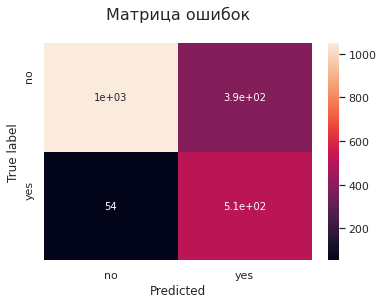

In [81]:
# выведем найденные параметры лучшей модели
print('Параметры модели:')
display(model.best_params_)

# посмотрим на метрики и матрицу ошибок
classification_metrics(y_test, y_pred)

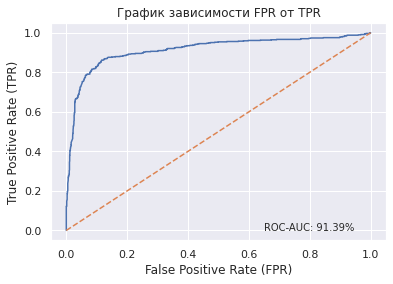

In [82]:
## выведем ROC-кривую
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba, pos_label=1)

# график зависимости FPR от TPR
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.plot([0,1], [0,1], linestyle='dashed')
plt.text(0.65, 0, f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.2%}")
plt.show()

Проведем анализ важности признаков. С помощью него мы сможем оценить вклад признаков в предсказание модели и на основе этого дать рекомендации бизнесу.

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros


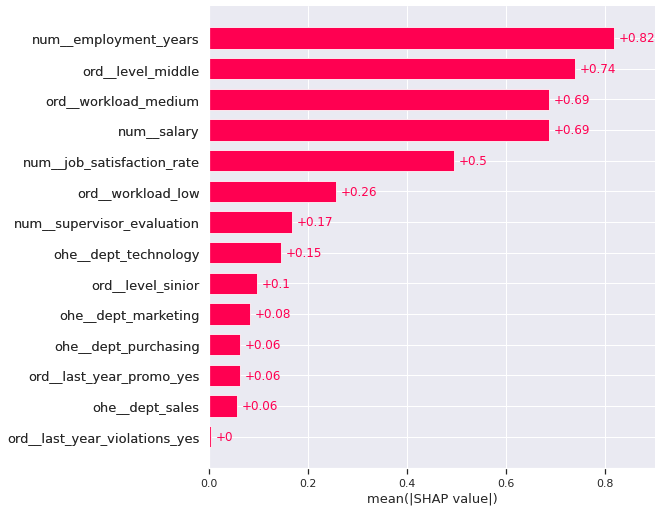

In [84]:
# сохраняем названия столбцов после предобработки, тренировочную и тестовую выборки
feature_names = model.best_estimator_['columntransformer'].get_feature_names_out()
X_train_p = pd.DataFrame(model.best_estimator_['columntransformer'].fit_transform(X_train), columns=feature_names)
X_test_p = pd.DataFrame(model.best_estimator_['columntransformer'].transform(X_test), columns=feature_names)

# обучаем модель
estimator = model.best_estimator_[-1].fit(X_train_p, y_train)

# рассчитываем SHAP-значения
explainer = shap.LinearExplainer(estimator, X_test_p, feature_names=feature_names)
shap_values = explainer(X_test_p)

# строим диаграмму
shap.plots.bar(shap_values, max_display=14)

Меньше всего влияет на предсказание увольнения сотрудника факт нарушения трудового договора, повышения и департамент, в котором работает сотрудник. Сильнее всего на предсказание влияет `employment_years` - стаж работы сотрудника в компании. Также в топе важных признаков средняя загруженность, уровень сотрудника мидл, показатели удовлетворенности и зарплаты сотрудника.

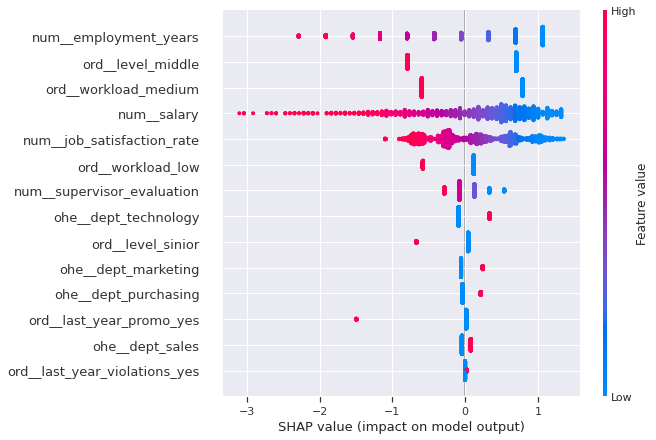

In [85]:
# строим диаграмму beeswarm, чтобы оценить как признаки влияют на положительный или отрицательный прогноз модели
shap.plots.beeswarm(shap_values, max_display=14)

По графику можно заметить, что чем меньше уровень удовлетворенности, тем больше вероятность увольнения сотрудника - логичный вывод. Также интересно, что мидлы со средней загруженностью, обычно, остаются в компании. По стажу работы в компании и зарплате тоже закономерные выводы - чем меньше сотрудник работает в компании и чем меньше у него зарплата, тем с большей вероятностью он уволится.

### Выводы по задаче

В результате поиска наилучшей модели классификации с оценкой качества модели по метрике ROC-AUC, модель `LogisticRegression` оказалась наилучшей среди прочих. Параметры модели: `LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')`. Эта модель лучше других смогла уловить зависимости в данных (которые, по всей видимости, близки к линейным).

Результат на тестовой выборке (ROC-AUC = 0.914) превышает необходимое по брифу пороговое значение данной метрики в 0.91.

Также данная модель имеет высокий показатель Recall (0.90). Такая модель будет давать меньше ложноотрицательных прогнозов (т.е. модель предсказала, что сотрудник не уволится, а он уволился). Это важно, т.к. бизнесу важно в первую очередь знать кто из сотрудников уволится, чтобы лучше контролировать отток персонала.

## Общий вывод

В ходе выполнения проекта по оптимизации управления персоналом для компании "Работа с Заботой" были решены две важные задачи с использованием методов машинного обучения.

---

**Первая задача:**

Первая задача заключалась в разработке модели для предсказании уровня удовлетворенности сотрудника на основе предоставленных данных.

Для решения задачи бизнесом было предоставлено несколько наборов данных:
- `train_job_satisfaction_rate.csv` - тренировочная выборка;
- `test_features.csv` - входные признаки тестовой выборки;
- `test_target_job_satisfaction_rate.csv` - целевой признак тестовой выборки.

В процессе предобработки данных были проведены следующие шаги:
- загрузка датасетов и проверка соответствия данных описанию;
- проверка на неявные дубликаты;
- проверка на ошибки разночтения;
- удаление возникших при установке индексов дубликаты в тренировочном фрейме.

На следующем шаге был проведен исследовательский анализ данных, в ходе которого были сделаны следующие выводы:
- среди количественных переменных имеется 2 дискретных (`employment_years` и `supervisor_evaluation`) и 2 непрерывных признака (`salary` и `job_satisfaction_rate`);
- выбросы в данных, судя по боксплотам, есть в показателе оценки от руководителя (оценка 1) и в области высоких зарплат - решено их оставить;
- распределение целевой переменной `job_satisfaction_rate` является бимодальным с первой модой 0.4 и второй модой 0.7;
- распределение признаков в тестовой выборке соответствует распределению в тренировочной выборке, следовательно разделение на выборки было корректным;
- с целевой переменной отсутствует/практически отсутствует корреляция у следующих признаков: `dept`, `level` и `workload` - решено их пока не удалять;
- сильнее всего на целевую переменную влияет оценка качества работы сотрудника, которую дал руководитель - `supervisor_evaluation`;
- мультиколлинеарности не обнаружено - максимальный межпризнаковый коэффициент корреляции равен 0.79.

Далее был подготовлен пайплайн для подготовки данных `col_transform`, включающий в себя масштабирование количественных признаков с помощью `StandardScaler()` и кодирование качественных признаков с помощью `OneHotEncoder()` и `OrdinalEncoder()`.

Следующий этап - поиск лучшей модели. Для этого был создан список моделей и диапазоны их гиперпараметров, в пределах которых проходил поиск лучшей модели. Подбор гиперпараметров осуществляли с помощью GridSearchCV с кросс-валидацией.

Модели и диапазоны гиперпараметров:
1. `LinearRegression` - линейная регрессия;
2. `Lasso` - регрессия с l1-регуляризацией:
    - `alpha`: от 1 до 10;
3. `Ridge` - регрессия с l2-регуляризацией:
    - `alpha`: от 1 до 10;
4. `DecisionTreeRegressor` - дерево решений для регрессии:
    - `max_depth`: от 2 до 20;
    - `min_samples_leaf`: от 1 до 5;
    - `min_samples_split`: от 2 до 5.

Оценка качества моделей проводили по метрике SMAPE. Для использования данной метрики, была написана функция `get_smape`, реализующая механизм расчета метрики и создана пользовательская метрика с помощью `make_scorer()`.

Лучшей моделью оказалась модель решающего дерева `DecisionTreeRegressor(max_depth=19, min_samples_leaf=3, min_samples_split=2, random_state=42)` - метрика SMAPE на кросс-валидации по тренировочной выборке равнялась 15.28, а на тестовых данных - 13.49, что удовлетворяет требованиям брифа $SMAPE ≤ 15$.

---

**Вторая задача: предсказание увольнения сотрудника из компании**

Вторая задача заключалась в разработке модели, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Для решения задачи бизнесом также было предоставлено несколько наборов данных:
- `train_quit.csv` - тренировочная выборка;
- `test_features.csv` - входные признаки тестовой выборки (тот же датасет, что и в первой задаче);
- `test_target_quit.csv` - целевой признак тестовой выборки.

В процессе предобработки данных, как и в первой задаче, были проведены шаги по проверке соответствия данных описанию, проверки на неявные дубликаты и ошибки разночтения, а также удалены возникших при установке `id` в качестве индексов дубликаты в тренировочном фрейме.

В результате EDA были получены следующие выводы:
- характер распределения количественных и качественных признаков аналогичен данным из первой задачи;
- выявлен дисбаланс классов в целевом признаке `quit` - объектов класса `no` в 3 раза больше, чем `yes`;
- с целевой переменной отсутствует корреляция у признака `dept`;
- сильнее всего на целевую переменную влияет длительность работы в компании - `employment_years`;
- мультиколлинеарность не обнаружена - максимальный межпризнаковый коэффициент корреляции равен 0.77.

Также был составлен портрет уволившегося сотрудника:
- мог работать в любом отделе, однако чуть более вероятнее - в отделе закупок;
- джун, с опытом работы в компании менее 3 лет;
- с низкой загруженностью;
- получал меньше, чем оставшиеся сотрудники (для джунов разница в 18%);
- получил низкую оценку работы от руководителя;
- не получал повышение за последний год;
- возможно, нарушал за последний год трудовой договор.

В рамках данного анализа также было проверено утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. В результате выяснилось, что уволившиеся сотрудники действительно были сильнее неудовлетворены работой в компании, чем оставшиеся. Их медианный уровень удовлетворенности равен 0.37 против 0.66 у оставшихся сотрудников. Учитывая наличия данного влияния, в тренировочную и тестовую выборки были добавлены спрогнозированные моделью из первой задачи значения удовлетворенности сотрудников. 

Далее была проведена подготовка данных с использованием пайплайна `col_transform` из первой задачи (при этом заново определили список количественных признаков, т.к. был добавлен новый признак `job_satisfaction_rate`, и повторно инициировали `col_transform`, чтобы новый признак тоже обработался).

Следующим этапом был поиск лучшей модели классификации по метрике ROC-AUC. Для этого нам также, как и в первой задаче, необходимо было задать список моделей и диапазоны их гиперпараметров, в пределах которых мы будем искать лучшую модель. Подбор гиперпараметров осуществляли с помощью RandomizedSearchCV с кросс-валидацией. Также, где это возможно, было применено взвешивание классов, чтобы устранить дисбаланс классов.

Модели и диапазоны гиперпараметров:
1. `LogisticRegression()`:
    - регуляризация `l1` и `l2`;
    - `С`: от 1 до 5.
2. `KNeighborsClassifier()`:
    - `n_neighbors`: от 2 до 15.
3. `SVC()`:
    - `kernel`: `rbf`, `sigmoid` и `poly`;
    - `C`: от 1 до 5;
    - `γ`: от 1 до 5.
4. `DecisionTreeClassifier()`:
    - `max_depth`: от 2 до 20;
    - `min_samples_leaf`: от 1 до 10;
    - `min_samples_split`: от 2 до 10.

Помимо основной метрики ROC-AUC контролировали метрику Recall, по которой можно определить, как часто модель дает ложноотрицательные прогнозы класса (т.е. модель предсказала, что сотрудник не уволится, а он уволился). Это важно, т.к. бизнесу нужно в первую очередь знать кто из сотрудников уволится, чтобы лучше контролировать отток персонала.

В результате была получена лучшая модель: `LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')`. Эта модель лучше других смогла уловить зависимости в данных (которые, по всей видимости, близки к линейным).

Модель показала значение метрики ROC-AUC на кросс-валидации по тренировочной выборке 0.91, а recall - 0.88. На тестовой выборке ROC-AUC составил 0.91, что удовлетворяет требованиям брифа $ROC-AUC ≥ 0.91$. Смещение модели по ROC-AUC составило 8.86%, разброс - 0.25%.

Также был проведен дополнительный анализ важности признаков, чтобы оценить на какие показатели следует обращать внимание в первую очередь при оценке вероятности увольнения сотрудника. Так, было выяснено, что на вероятность увольнения сотрудника больше всего влияет уровень его удовлетворенности работы в компании, а также соотношение его грейда, загруженности и зарплаты. В зоне риска для компании находятся джуны с небольшим стажем работы в компании и зарплатой ниже среднего. В качестве рекомендации для бизнеса можно посоветовать работать с мотивацией данного сегмента сотрудников.